In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import optax
from parent_dir import *
from data_gen import data_generator
import qutip
import gc
import os
import ipynbname  #! pip install ipynbname
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_provider import IBMProvider
from qiskit_aer.noise import NoiseModel
from sklearn.model_selection import train_test_split

In [2]:
#nb_fname = ipynbname.name()
#ver = nb_fname[nb_fname.index('v'):nb_fname.index('_')]

In [3]:
# Added to silence some warnings.
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')

In [4]:
ver = 'v9.9t'
problem = 'breast_cancer' #'3 circles'#'moon'#
shape =  "binary" #"bitwise" #"square plane"#"tetrahedron"#
rot = 'zyz' #'yzy' #'xzx' #
num_training = 400
num_test = 100

enc_dim = 3
num_qubits = 5
num_layers = 1
num_reupload = 1
num_rot = 1

max_n_converge = 10
thres_converge = 0.0001
preprocess = "scaling"#None #  "normalization"# "standardization" #
seed_num = data_seed_num= 40#

In [ ]:
noise = training_noise = False#True#
fake_backend = False#True#
real_device =  False#True#
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
#provider = IBMProvider(instance='ibm-q/open/main')
backend = 'ibm_cusco'#'ibmq_jakarta'#'ibm_brisbane'#'ibmq_lima'#'ibmq_belem'#'ibmq_manila'#'ibmq_quito'#'ibm_lagos'#'ibm_nairobi'#''ibm_perth',#'ibm_oslo'#'ibmq_belem'#'ibmq_qasm_simulator'
#backend = provider.get_backend(backend)
#IBMProvider.save_account('')

date, day = time.strftime("%Y%m%d-%H%M"), time.strftime("%Y%m%d-%H")
cwd = os.getcwd()

In [6]:
import random
num_cvs = 5
num_seeds = 10
random.seed(seed_num)
seeds = [random.randint(0, 1E3) for _ in range(num_seeds)]
seeds

[469, 593, 898, 536, 32, 251, 289, 680, 984, 652]

In [7]:
# set range of aubits and rotations
settings, results= [], []
num_settings = r_enc, r_q ,r_f, r_r, r_rot = 1, 7, 1, 1, 1 #run the setting with n values
start_value = e0, q0, f0, r0, rot0 = 5, 1, 1, 3, 3

for e in range(r_enc):
    e = e+1 if r_enc!=1 else e0
    for q in range(r_q):
        q = q+1 if r_q!=1 else q0
        for f in range(r_f):
            f = f+1 if r_f!=1 else f0
            for r in range(r_r):
                r = r+1 if r_r!=1 else r0
                for n_rot in range(r_rot):
                    n_rot = n_rot+1 if r_rot!=1 else rot0
                    settings.append([e,q,f,r,n_rot] )

settings#=settings[:3]

[[5, 1, 1, 3, 3],
 [5, 2, 1, 3, 3],
 [5, 3, 1, 3, 3],
 [5, 4, 1, 3, 3],
 [5, 5, 1, 3, 3],
 [5, 6, 1, 3, 3],
 [5, 7, 1, 3, 3]]

In [8]:
h_params= {'lr':[[0.15,0.05,0.01],[0.15,0.05,0.01,0.001,0.0001]],  #
           'max_epoch':[3200],
           'batch_size':[50,100,300],
           'dynamic_size':[50],
           'thres':[[0.05,0.03,0.01]]}#]}#[0.05],
h_pms = [[i,j,k,l,m] for i in h_params['lr'] for j in h_params['max_epoch'] for k in h_params['batch_size'] for l in h_params['dynamic_size'] for m in h_params['thres']]
h_pms#=h_pms[:3]
h_pms

[[[0.15, 0.05, 0.01], 3200, 50, 50, [0.05, 0.03, 0.01]],
 [[0.15, 0.05, 0.01], 3200, 100, 50, [0.05, 0.03, 0.01]],
 [[0.15, 0.05, 0.01], 3200, 300, 50, [0.05, 0.03, 0.01]],
 [[0.15, 0.05, 0.01, 0.001, 0.0001], 3200, 50, 50, [0.05, 0.03, 0.01]],
 [[0.15, 0.05, 0.01, 0.001, 0.0001], 3200, 100, 50, [0.05, 0.03, 0.01]],
 [[0.15, 0.05, 0.01, 0.001, 0.0001], 3200, 300, 50, [0.05, 0.03, 0.01]]]

In [9]:
def model_noise(backend,fake_backend):
    #noise_model = None
    if fake_backend:   
        model_dict = {}
        i_bknd = backend.index('_')+1
        f_bknd = 'Fake'+backend[i_bknd].upper()+backend[i_bknd+1:]+'V2'
        import_str = "from {0} import {1}".format('qiskit.providers.fake_provider',f_bknd)
        exec(import_str,globals(),model_dict)
        exec('noise_model = NoiseModel.from_backend({})'.format(f_bknd+'()'),globals(),model_dict)
        noise_model = model_dict['noise_model']
    else:
        noise_model = NoiseModel.from_backend(provider.get_backend(backend)) #backend = provider.get_backend(backend)
    return noise_model
noise_model = model_noise(backend,fake_backend)

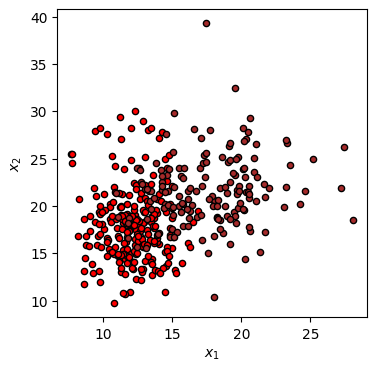

In [10]:
#key = jax.random.PRNGKey(seed_num)
def data_gen(problem,num_training=num_training, seed_num = 42):
    np.random.seed(seed_num)
    data=data_generator(problem,num_training)[0]
    x=np.array([i[0] for i in data])#.astype(float)
    y=np.array([i[1] for i in data])#.astype(float)
    return x,y #torch.tensor(x),torch.tensor(y)
    
def plot_data(x, y, fig=None, ax=None):
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    brown = y == 0
    reds = y == 1
    green = y == 2
    blues = y == 3
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.scatter(x[green, 0], x[green, 1], c="green", s=20, edgecolor="k")
    ax.scatter(x[brown, 0], x[brown, 1], c="brown", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    
Xdata, ydata = data_gen(problem,num_training)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

theta= [0, 3.141592653589793] 
phi= [0, 0]
c_states= [[[1.000000e+00+0.j]
  [0.000000e+00+0.j]]

 [[6.123234e-17+0.j]
  [1.000000e+00+0.j]]] 
shape: (2, 2, 1)


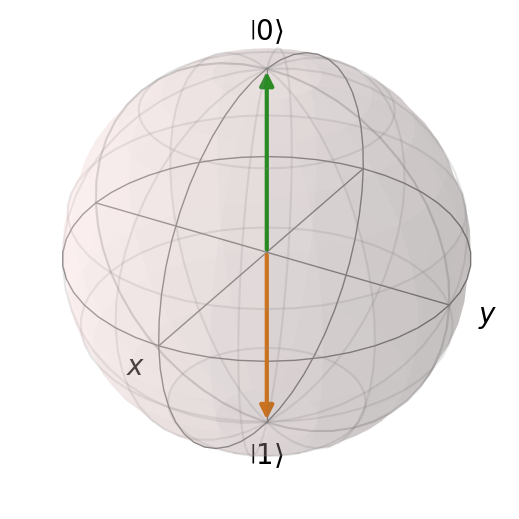

Array([[1.00000000e+00, 3.74939946e-33],
       [3.74939946e-33, 1.00000000e+00]], dtype=float64)

In [11]:
# Define output labels as quantum state vectors
def density_matrix(state):
    return state * np.conj(state).T

def state_labels(theta, phi):
    return [np.cos(np.array(a)/2)*label_0+np.exp(np.array(b)*1j)*np.sin(np.array(a)/2)*label_1 for a,b in zip(theta, phi)]

def plot_class_states(dm_labels, bloch3d=False):
    if bloch3d:
        b = qutip.Bloch() 
        b3d = qutip.Bloch3d()  #need Mayavi,PyQt
        for i in state_labels(theta, phi):
            s=(i[0,0]*qutip.basis(2, 0) + i[1,0]*qutip.basis(2, 1)).unit()
            b.add_states(s)
            b3d.add_states(s)
        b.show()
        b3d.show()
    else:
        b = qutip.Bloch() 
        for i in state_labels(theta, phi):
            s=(i[0,0]*qutip.basis(2, 0) + i[1,0]*qutip.basis(2, 1)).unit()
            b.add_states(s)
        b.show()
        
#Bloch sphere representation: 
#psi = alpha|0> + beta|1> = cos(theta/2)+e^(i*phi)sin(theta/2)


def angles(shape):
    shapes = ["square plane", "tetrahedron", "bitwise","binary"]
    shape = shape.lower()
    if shape not in shapes:
        raise ValueError('problem must be one of {}'.format(shapes))
    if shape == "square plane":
        theta = [np.pi/2]*4
        phi = [np.pi/4, -np.pi/4, 3*np.pi/4, -3*np.pi/4]
    if shape == "tetrahedron":
        X = [[0, 0], [0,1], [1,0],[1,1]]
        enc = []
        for x in X:
            MyEnc = [None, None]
            if x[0] or x[1]:
                #MyEnc[0] = 2*np.arccos(1/np.sqrt(3))
                MyEnc[0] = np.arccos(-1/3)
            else:
                MyEnc[0] = 0
            MyEnc[1] = (x[0]*2 + x[1])*2*np.pi/3
            enc.append(MyEnc)
            Enc = np.array(enc).T
        theta, phi = Enc[0], Enc[1]
    if shape in ["bitwise","binary"]:
        theta = [0,np.pi]
        phi = [0,0]
    return theta, phi

def yc(c_states,num_qubits=2): #mutual fidelities of c_states
    Yc = jnp.array([(np.abs(i.T.conj().dot(j)))**2 for i in c_states for j in c_states])
    Yc = Yc.reshape([num_class,num_class])
    if shape == "bitwise":
        for i in range(num_qubits-1):
            Yc = jnp.kron(Yc, Yc)
    return Yc
label_0 = np.array([[1.], [0.]])
label_1 = np.array([[0.], [1.]])

theta, phi = angles(shape)
num_class = len(theta)     # of class for one qubit
print('theta=',theta,'\nphi=',phi)
c_states = jnp.array(state_labels(theta, phi))
print('c_states=',c_states,'\nshape:',c_states.shape)
dm_labels = jnp.array([density_matrix(s) for s in c_states])
plot_class_states(dm_labels, bloch3d=False)  
# if 3d has err: pip install mayavi PyQt5 
# and see https://stackoverflow.com/questions/72110384/libgl-error-mesa-loader-failed-to-open-iris
# or https://askubuntu.com/questions/1418016/glibcxx-3-4-30-not-found-in-conda-environment
Yc = yc(c_states)

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a.tolist()
dm_labels = totuple(dm_labels)
Yc

In [12]:
noise = training_noise
def device(num_qubits,noise=False,real_device=False,backend=backend,noise_model=None):
    if noise:
        if real_device:
            dev = qml.device('qiskit.ibmq.circuit_runner', wires=num_qubits, backend=backend, 
                             provider=provider,initial_layout= [1,2],start_session=True)#)#
        else:
            if not noise_model:
                noise_model = model_noise(backend,fake_backend)
            dev = qml.device('qiskit.aer', wires=num_qubits, diff_method="adjoint", noise_model=noise_model)#
    else: 
        dev = qml.device("default.qubit", wires=num_qubits)
    return dev
def conditional_qnode(f):
    def wrapper(*args):
        self = args[0]
        if self.noise:
            return qml.QNode(f,self.dev)(*args)
        else: 
            return qml.QNode(f,self.dev,interface='jax')(*args)
    return wrapper

In [13]:
class qcircuit:
    dev = device(num_qubits,noise,real_device,backend,noise_model)
    def __init__(self,params, x, y, n_qubits, n_layers, n_reupload, n_rot, enc_dim=2): 
        import math
        self.dev = device(num_qubits,noise,real_device,backend,noise_model)
        self.x = x
        self.y = y
        self.n_rot = n_rot
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_reupload = n_reupload
        
        self.N = len(x[0])                                 # # of examples, and x = X_train.T
        self.noise = noise
        self.params = params   
        self.dim_x = (len(x))                              # dimension of x
        self.enc_dim = enc_dim
        self.least_q = math.ceil(self.dim_x/enc_dim)       # least qubit # for encoding
        if self.least_q>n_qubits: raise ValueError("Number of qubits not enough for encoding features.")
        
    def reshape_input(self,x_in): #'''May cause some prob ex. dim_in=4, enc_dim=3, q=5 e.g. not all enc_dim is filled'''
        enc_dim , n_qubits = self.enc_dim, self.n_qubits
        self.dim_in = len(x_in)
        if n_qubits*enc_dim >= self.dim_in*2:       # repeat to fill all qubits
            self.rep = n_qubits*enc_dim//self.dim_in
            x_in = jnp.tile(x_in,(self.rep,1))
        if remain_dim:=enc_dim*n_qubits-len(x_in):           # make x_in be integer multiple of enc_dim
            x_in = jnp.vstack((np.zeros((remain_dim,self.N)), x_in)) 
        x_in = x_in.reshape(len(x_in)//enc_dim,enc_dim,self.N) # (least_q_#,enc_dim,N) ## each qubit have enc_dim input dims
        return x_in
    def encode_op(self,x):
        op = ()
        #print(x[0][0].shape)
        for q in range(self.n_qubits):
            for e_i in range(self.enc_dim):
                if even := (e_i+1)%2:   #Rx(0)Rx(2)...
                    op = op+(qml.RX(x[q][e_i], wires=q),)
                    if e_i>=len(x[0]): op = op+(qml.RX(0, wires=q),)  ;print('Warning: # of encoding features is more than enc_dim.')                   
                else:                   #Ry(1)Ry(3)...
                    op = op+(qml.RY(x[q][e_i], wires=q),)
                    if e_i>=len(x[0]): op = op+(qml.RY(0, wires=q),)  ;print('Warning: # of encoding features is more than enc_dim.') 
                    # Notice that JAX don't have IndexError: out of bound error.
                    # It simply returns the last results.
        return op

    def reupload_op(self,x):
        op=()
        for q in range(self.n_qubits):
            for e_i in range(self.enc_dim):
                if even := (e_i+1)%2:   #RxRyRxRy...(0,1,2,...)
                    op = op+(qml.RX(x[q][e_i], wires=q),)
                    if e_i>=len(x[0]): op = op+(qml.RX(0, wires=q),)  ;print('Warning: # of encoding features is more than enc_dim.')                   
                else:
                    op = op+(qml.RY(x[q][e_i], wires=q),)
                    if e_i>=len(x[0]): op = op+(qml.RY(0, wires=q),)  ;print('Warning: # of encoding features is more than enc_dim.') 
        return op

    def rot_op(self,p):
        op = ()
        #p = self.params['params'][0]
        rots = ["zyz", "xzx", "yzy"]
        if rot not in rots:
            raise ValueError('rotation must be one of {}'.format(rots))
        if rot=='zyz':
            for n_rot in range(self.n_rot):
                for q in range(self.n_qubits):
                    op = op+(qml.Rot(*p[q,n_rot], wires=q),)
                    op = op+(qml.CNOT(wires=[q-1,q]),) if q != 0 else op
        if rot=='xzx':
            for n_rot in range(self.n_rot):
                for q in range(self.n_qubits):
                    op = op+(qml.Rot(*p[q,n_rot], wires=q),)
                    op = op+(qml.CNOT(wires=[q-1,q]),) if q != 0 else op
        if rot=='yzy':
            for n_rot in range(self.n_rot):
                for q in range(self.n_qubits):
                    op = op+(qml.Rot(*p[q,n_rot], wires=q),)
                    op = op+(qml.CNOT(wires=[q-1,q]),) if q != 0 else op
        return op

    # @qml.qnode(dev,interface='jax')   ## To print circuit, use @qml.qnode instead of @conditional_qnode
    @conditional_qnode
    def enc_circuit(self,p, x):
        # p0=p['scaling']
        # p0=jnp.tile(p0,(self.n_qubits,1))
        for r_j in range(self.n_reupload):
            p1 = p['scaling'][r_j][:len(x)]#
            p2 = p['circ'][r_j]
            p1=jnp.tile(p1.reshape(len(x),self.enc_dim,1),(1,1,self.N))

            x2 = x*p1
            #x2=[x[0],x[1]*p[12],x[2]*p[13],x[3]*p[14],x[4]*p[15],x[5]*p[16]] if problem=='breast_cancer' else [x[:,0],x[:,1]*p[12],x[:,2]*p[13]]
            qml.apply(self.encode_op(x2))
            qml.apply(self.rot_op(p2))
            
        return [qml.expval(qml.PauliZ(q)) for q in range(self.n_qubits)]

    @conditional_qnode
    def circuit(self,p, x):
        #p0 = p['params']
        #x2=[x[0],x[1]*p0[12],x[2]*p0[13]]
        x1 = jnp.tile(x,(self.enc_dim,1,1)).reshape(self.n_qubits,self.enc_dim,self.N) # (q,N)->(enc,q,N)->(q,enc,N)
        for r_j in range(self.n_reupload):
            p1 = p['scaling'][r_j]
            p2 = p['circ'][r_j]
            p1=jnp.tile(p1.reshape(self.n_qubits,self.enc_dim,1),(1,1,self.N))
            x2 = p1*x1
            qml.apply(self.reupload_op(x2))
            qml.apply(self.rot_op(p2))
        
        return [qml.expval(qml.PauliZ(q)) for q in range(self.n_qubits)]
    
    # @qml.qnode(dev,interface='jax')
    @conditional_qnode
    def circuit_end(self,p, x, y):
        y=np.array(y)
        for r_j in range(self.n_reupload):
            p1 = p['scaling'][r_j]
            p2 = p['circ'][r_j]
            p1=jnp.tile(p1.reshape(self.n_qubits,self.enc_dim,1),(1,1,self.N))
            # p = p['params']
            # x2=[x[0],x[1]*p[12],x[2]*p[13]]
            if self.n_layers==1:
                # x2=[x[0],x[1]*p[12],x[2]*p[13],x[3]*p[14],x[4]*p[15],x[5]*p[16]] if problem=='breast_cancer' else [x[0],x[1]*p[12],x[2]*p[13]]
                x2 = x*p1
                qml.apply(self.encode_op(x2))
            else:
                x1 = jnp.tile(x,(self.enc_dim,1,1)).reshape(self.n_qubits,self.enc_dim,self.N) # (q,N)->(enc,q,N)->(q,enc,N)
                x2 = x1*p1
                qml.apply(self.reupload_op(x2))        
            qml.apply(self.rot_op(p2))
        return [qml.expval(qml.Hermitian(y, wires=[q])) for q in range(self.n_qubits)] 
        #return qml.expval(qml.Hermitian(y, wires=[0])) ,qml.expval(qml.Hermitian(y, wires=[1]))

    def qc_2q(self):
        x = self.reshape_input(self.x)
        params, y = self.params, self.y    
        for f_i in range(self.n_layers-1):
            #p = params[f_i]
            #print(x.shape)
            x = jnp.array(ocs)
            p = {i:j[f_i] for i,j in params.items()}
            ocs = self.enc_circuit(p, x) if f_i==0 else self.circuit(p, x)
            # ocs =  self.enc_circuit(self,p, x) if f_i==0 else self.circuit(p, x)
            # print(qml.draw(self.enc_circuit)(self,p, x)) ## To print circuit, use @qml.qnode instead of @conditional_qnode 

            
        p = {i:j[self.n_layers-1] for i,j in params.items()}
        #p = params[self.n_layers-1]
        ocs =  self.circuit_end(p, x, y)
        x = ocs
        return ocs
    jqc_2q = jax.jit(qc_2q, static_argnums=(0))

In [14]:
# a=qcircuit(params, jnp.array([X_train[:,0],X_train[:,1]]), dm_labels[0],num_qubits, num_layers,num_reupload,num_rot,enc_dim)
# zzz = a.qc_2q()

In [15]:
# a=qcircuit(params, jnp.array([X_train[:,0],X_train[:,1]]), dm_labels[0], n_qubits, num_layers,enc_dim)
# ccc = a.jqc_2q()

In [16]:
#zzz[1]-ccc[1]

In [17]:
def test(params, x, y, *args, **kwargs):
    # args : num_qubits,num_layers,num_reupload,num_rot,enc_dim
    #num_qubits,num_layers,num_reupload,num_rot,enc_dim = args if args else [None]*5
        
    def fidel_function(params, x_i,y):  
        qc = qcircuit(params, x_i, y, num_qubits,num_layers,num_reupload,num_rot,enc_dim)
        if noise:
            return qc.qc_2q()
        else:
            print('circuit is jitted')
            return qc.jqc_2q()

    def jloss(params,fidelities,y_i):
        b = 1 if shape=="bitwise" else 0        
        #print('fidelities',fidelities.shape)
        return sum([1/2*(params[num_layers+i,j]*fidelities[i,j]-Yc[y_i,2*i*b+j])**2 for  i in range(num_qubits) for j in range(num_class)])    
        #return sum([-(Yc[y_i,2*i*b+j]*jnp.log(fidelities[i,j])) for  i in range(num_qubits) for j in range(num_class)])    
        
    def cost(params,x,y):
        x_in = x.T   #[[0 vector],[x1 vector],[x2 vector]]
        loss = 0
        predicted = []
        #print('yshape',y.shape)
        tot_fidelities = jnp.array([fidel_function(params, x_in, dm) for dm in dm_labels]).T #shape:(N,#qubit,#class)
        tot_fidelities = tot_fidelities.reshape(len(y),num_qubits,num_class)
        
        tot_fids = jax.vmap(jnp.kron,(0,0),0)(tot_fidelities[:,0],tot_fidelities[:,1]).reshape(len(y),num_qubits,num_class) if shape=="bitwise" else tot_fidelities
        Loss = jax.vmap(jloss,(None,0,0))(params['loss'],tot_fids,y)
        Loss = jnp.sum(Loss)/len(y)/num_qubits
        predicted = jax.vmap(np.argmax)(tot_fids) if shape == "bitwise" else jax.vmap(np.argmax)(tot_fids)%num_class
        return Loss, predicted

    '''for diff input to same fun., if u take grad after operation it will csuse error
       But do operation seperately (for diff input) and add together is ok '''
    '''grad go to 0 if u diff over fun of fun； 
       which is: diff(fun(p)) is ok, but if f=fun(p), diff(f) is 0  
       2022/12/26'''
    (loss,predicted), grad = jax.value_and_grad(cost, has_aux=True)(params,x,y)
    return jnp.array(predicted), loss, grad

jtest =  test if noise else jax.jit(test) 

In [18]:
#@jax.jit
def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum().astype(int) / len(y_true)

def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0], batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [19]:
def scores(params, x_tr, y_tr, x_te=None, y_te=None, report=False):
    
    predicted_train, loss , grads = jtest(params, x_tr, y_tr)
    accuracy_train = accuracy_score(y_tr, predicted_train)
    
    if x_te is None and y_te is None:
        return accuracy_train, loss  
    else:
        predicted_test, loss_test , grads_test = jtest(params, x_te, y_te)
        accuracy_test = accuracy_score(y_te, predicted_test)
        if report:
            from sklearn.metrics import classification_report
            return classification_report(y_te, predicted_test)
        else:
            return accuracy_train, loss, accuracy_test, loss_test    

In [20]:
def initialize_data(problem,n_training=None,n_test=None,seed_num=0,enc_dim=3):
    def normalize(x,preprocess='scaling'):
        from sklearn import preprocessing  
        if preprocess:
            preprocess = preprocess.lower()
            preprocesses = ["standardization", "scaling", "normalization"]
            if preprocess not in preprocesses:
                raise ValueError(f'preprocess must be one of {preprocesses}')
            if preprocess == 'standardization':
                x = preprocessing.StandardScaler().fit(x).transform(x)*2*np.pi
            if preprocess == 'scaling':
                x = preprocessing.MinMaxScaler().fit_transform(x)*2*np.pi
            if preprocess == 'normalization':
                x = preprocessing.normalize(x, norm='l2')*2*np.pi
        return x

    if problem=='breast_cancer':
        if n_training>569:
            raise ValueError('num_training must < 569')
        if n_test: global num_test # in order to change the global value of num_test
        if num_test > 569-n_training:
            num_test = n_test = 569-n_training
            print('Warning: num_test is set to', num_test)
        x,y = data_gen(problem,569,seed_num=seed_num)
        Xtrain, Xtest, y_train, y_test = train_test_split(
            x,y,test_size=n_test,train_size=n_training,
            random_state=seed_num,stratify=y)
    else:
        Xtrain, y_train = data_gen(problem,n_training,seed_num=seed_num)
        Xtest, y_test = data_gen(problem,n_test,seed_num=np.random.randint(1e6))
    
    X_train = Xtrain
    X_test = Xtest
        
    X_train = normalize(X_train,preprocess)
    X_test = normalize(X_test,preprocess)
    

    if n_training and n_test:
        return X_train, y_train, X_test, y_test
    else:
        if n_training:
            return X_train, y_train
        else:
            return X_test, y_test

In [21]:
# problem = 'breast_cancer'#'3 circles'#'moon'#
# shape =  "binary"#"tetrahedron"#"bitwise" #"square plane"#
# rot = 'zyz'#'yzy' #'xzx' #
# num_training = 400
# num_test = 500

# num_qubits = 2
# num_layers = 5

# #learning_rate,epochs,batch_size,dynamic_size,threshold = [0.15,0.05,0.01], 3000 , 50,20, [0.05]
# #learning_rate,epochs,batch_size,dynamic_size,threshold = [0.15,0.05,0.01,0.002,0.01],20000, 50,20, [0.05]#50, 0.01
# learning_rate,epochs,batch_size,dynamic_size,threshold = [0.15,0.05,0.01,0.001,0.0001],60000, 400, 50, [0.05,0.05,0.005,0.0001]#50, 0.01
# preprocess =  "scaling" #"standardization" # "normalization" #None#
# seed_num = 42#

In [22]:
# ##
# len_params = 12+enc_dim#len(X_train[0]) #12*params+dim_data*scaling factor
# params = initiallize_params(num_layers, num_reupload, num_qubits, len_params, enc_dim, seed_num)
# a=qcircuit(params, jnp.array([X_train[:,0],X_train[:,1]]), dm_labels[0],num_qubits, num_layers,num_reupload,enc_dim)
# zzz = a.qc_2q()

In [23]:
def initiallize_params(n_feedforward, n_reupload, n_qubits, enc_dim, n_rot, seed_num=40):
    num_layers = n_feedforward
    key = jax.random.PRNGKey(seed_num)
    key_s, key_c, key_l = jax.random.split(key,3)
    p_s = jax.random.uniform(key_s,(n_feedforward, n_reupload, n_qubits, enc_dim),dtype=jnp.float64) #12*params,2*scaling factor  
    p_c = jax.random.uniform(key_c,(n_feedforward, n_reupload, n_qubits, n_rot, 3),dtype=jnp.float64)
    p_l = jax.random.uniform(key_l,(n_qubits, num_class),dtype=jnp.float64)
    p = {'params':p_s,'scaling':p_s, 'circ':p_c,'loss':p_l}
    return p

In [24]:
# # Generate training and test data
# start = time.process_time()
# iter_lr = iter(learning_rate)
# iter_thres = iter(list(threshold))
# lr = next(iter_lr)
# thres_n = next(iter_thres)

# X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim)

# # initialize random weights
# len_params = 12+enc_dim#len(X_train[0]) #12*params+dim_data*scaling factor
# params = initiallize_params(num_layers, num_reupload, num_qubits, len_params, enc_dim, num_rot, seed_num)


# loss_history = []
# accuracy_history = []
# optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=lr)#optax.adam(learning_rate=0.05)
# opt_state = optimizer.init(params)

In [25]:
# predicted_train, loss , grads = jtest(params, X_train, y_train)
# accuracy_train = accuracy_score(y_train, predicted_train)
# predicted_test, loss_test , grads_test = jtest(params, X_test, y_test)
# accuracy_test = accuracy_score(y_test, predicted_test)

# # save predictions with random weights for comparison
# initial_predictions = predicted_test

# start2 = time.process_time()
# print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))
# print('compile time:',start2-start)

In [26]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation,opt_state,x,y,x_valid=None,y_valid=None) -> optax.Params:
  #opt_state = optimizer.init(params)
  def step(params, opt_state,x,y):
    loss_batches = jnp.array([])
    predicted_train = jnp.array([])
    iter_batch = iterate_minibatches(x, y, batch_size=batch_size)
    for x_batch, y_batch in iter_batch:
        predicted_batch, loss_batch , grads = jtest(params, x_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_batches = jax.numpy.append(loss_batches,loss_batch)
        predicted_train = jax.numpy.append(predicted_train, predicted_batch)
    loss_value = jnp.average(loss_batches)
    return params, opt_state, loss_value, predicted_train
  n_converge = 0

  
  #loss_history = []
  params_history = []
  state_history = []
  valid_accuracy_history=[]
  ave_loss = 1
  l_r = lr
  thres = thres_n
  for i  in range(max_epoch):
    i=i+1
    state_history.append(opt_state) #save value advance otherwise it saves the updated one
    params_history.append(params)
    
    params, opt_state, loss_value , predicted_train= step(params, opt_state, x, y)
    accuracy_train = accuracy_score(y, predicted_train)
    
    print(f'step {i}, accuracy_train:{accuracy_train}, loss: {loss_value}')
    if x_valid is not None and y_valid is not None:
        accuracy_valid, loss_valid = scores(params, x_valid, y_valid)
        valid_loss_history.append(float(loss_valid))
        valid_accuracy_history.append(float(accuracy_valid))
    loss_history.append(float(loss_value))    
    accuracy_history.append(float(accuracy_train))
    
    if i%dynamic_size==0:
        c_ave = sum(loss_history[-dynamic_size:])/dynamic_size #current loss average
        now_thres = abs(c_ave-ave_loss)/ave_loss
        print(now_thres)
        if  now_thres<=thres:
            try:
                l_r=next(iter_lr)#learning_rate
                #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size:])-dynamic_size
                loc_best_loss = np.argmin(loss_history[-dynamic_size:])-dynamic_size
                params = params_history[loc_best_loss]
                #print('best known accuracy:', accuracy_history[loc_best_accuracy]) #update lr based on accuracy
                print('accuracy of best loss :', accuracy_history[loc_best_loss]) #update lr based on loss
                
                opt_state.hyperparams['learning_rate'] = l_r
                #print('lr:', l_r, opt_state.hyperparams['learning_rate'])
                try:
                    thres = next(iter_thres)
                except StopIteration:
                    print(thres)
            except StopIteration:
                pass
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print(i)
        n_converge  = n_converge+1 if now_thres<thres_converge else 0
        ave_loss = c_ave
        
    if i==max_epoch or n_converge==max_n_converge:
        n_converge = 1 if n_converge==0 else n_converge 
        #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size*10:])-dynamic_size*10
        candidate_history = loss_history if x_valid is None else valid_loss_history
        loc_best_loss = np.argmin(candidate_history[-dynamic_size*n_converge:])-dynamic_size*n_converge
        params = params_history[loc_best_loss]
        opt_state = state_history[loc_best_loss]
        num_epoch = i
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print('accuracy of best loss:',accuracy_history[loc_best_loss],loc_best_loss)
        #print('best known accuracy:',accuracy_history[loc_best_loss],loc_best_loss)
        break
  return params, l_r, opt_state, num_epoch

In [27]:
if 'lay' not in ver:
    ver = ver+f'_lay{num_layers}'
    ver = ver+'_'+backend+'_'+date if noise else ver+'_'+date
#print(os.getcwd())
filename = ver[:ver.index('_')]
os.chdir(cwd)
if not os.path.exists('Figures/'+filename+'/'+day):
    try:
        os.mkdir('Figures/'+filename)
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except FileExistsError:
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except Exception as e:
        print(e)
else: os.chdir('Figures/'+filename+'/'+day)
print(os.getcwd())

/mnt/c/Users/paes20705/OneDrive/桌面/Main Programs/Python/Jupyter/Research/References/universal_qlassifier-master/test/Figures/v9.9t/20240720-16


In [28]:
def plot_loss_history(l_h, val_l_h=[], setting=None, fig_name=''):
    fig, ax = plt.subplots(1, 1)
    plt.plot(range(len(l_h)),l_h,color=(255/255,100/255,100/255),label='Loss')
    if val_l_h:
        plt.plot(range(len(val_l_h)),val_l_h,color='g',label='Validation loss')
    plt.title("Loss") # title
    plt.ylabel("loss") # y label
    plt.xlabel("epoch") # x label
    plt.legend()
    plt.show()
    if fig_name:
        fig.savefig('{}.png'.format(fig_name), transparent=True)
    elif fig_name is None:
        pass  #don't save, just print
    else:    
        fig.savefig('{}_loss.png'.format(setting), transparent=True)        

In [29]:
from sklearn.model_selection import StratifiedKFold
x,y, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim)

skf = StratifiedKFold(n_splits=5)
for index_tr, index_te in skf.split(x, y):
    cv_xtr, cv_ytr = x[index_tr], y[index_tr]
    cv_xte, cv_yte = x[index_te], y[index_te]
    print(cv_xtr.shape,cv_ytr.shape)

(320, 5) (320,)
(320, 5) (320,)
(320, 5) (320,)
(320, 5) (320,)
(320, 5) (320,)


In [30]:
def n_cv(n_fold, x, y, setting, *var, seed_num=42):
    from sklearn.utils import shuffle
    from sklearn.model_selection import StratifiedKFold
    global loss_history,valid_loss_history, accuracy_history, loss_history_cvs 
    global iter_lr, iter_thres, lr, thres_n
    
    skf = StratifiedKFold(n_splits=5)
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting 
    start = time.process_time()
    cv_rsts= []

    for index_tr, index_te in skf.split(x, y):
        cv_xtr, cv_ytr = x[index_tr], y[index_tr]
        cv_xte, cv_yte = x[index_te], y[index_te]
        
        iter_lr = iter(learning_rate)
        iter_thres = iter(list(threshold))
        lr = next(iter_lr)
        thres_n = next(iter_thres)
        
        # initialize random weights
        params = initiallize_params(num_layers, num_reupload, num_qubits, enc_dim, num_rot, seed_num)
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=lr)#optax.adam(learning_rate=0.05)
        opt_state = optimizer.init(params)

        loss_history = []
        valid_loss_history = []
        accuracy_history = []

        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, cv_xtr, cv_ytr, cv_xte, cv_yte)
        accuracy_train, loss, accuracy_test, loss_test = scores(params, cv_xtr, cv_ytr,cv_xte, cv_yte)
        loss_history_cvs.append([loss_history,valid_loss_history])
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))
        print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
        cv_rsts.append([accuracy_test, loss])
        plot_loss_history(loss_history, valid_loss_history, setting=setting, fig_name=None)
        
    end = time.process_time()
    print("cv_time ：%f s" % (end - start))
    return sum(np.array(cv_rsts)[:,0])/n_fold, sum(np.array(cv_rsts)[:,1])/n_fold

In [ ]:
# Grid search of hyper-parameters
best_h_pm, h_pm_rsts =[], []
cv_start = time.process_time()
for setting in settings:
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim)
    h_pm_rst=[]
    loss_history_cvs=[]
    for h_pm in h_pms:
        learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pm
        
        seed_rsts, seed_params = [], []
        loss_history, valid_loss_history = [], []
        accuracy_history = []
        h_pm_rst.append(n_cv(num_cvs, X_train, y_train,setting))
        print(h_pm)

        
    h_pm_i = np.argmax(h_pm_rst,axis=0)[0]
    best_h_pm.append(h_pm_i)
    h_pm_rsts.append(h_pm_rst)
    l_h_best, val_l_h_best = loss_history_cvs[h_pm_i]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting, fig_name=f'{setting}_loss_best_h_pms')
t_cvs = time.process_time()-cv_start

In [32]:
def run(seed_num, x_tr, y_tr, x_te=None, y_te=None, ratio_tr=0.875):
    #if:   x_te=None & y_te=None -> choosing random seed with validation accuracy
    #else: train and test
    global loss_history, valid_loss_history, lr    
    if x_te is None and y_te is None:
        from sklearn.utils import shuffle
        xs_tr, xs_val, ys_tr, ys_val = train_test_split(
            x_tr,y_tr,train_size=ratio_tr,random_state=seed_num,stratify=y_tr)
        # xs = shuffle(x_tr, random_state=seed_num, n_samples=None)
        # ys = shuffle(y_tr, random_state=seed_num, n_samples=None)
        # num_seed_train = int(num_training*ratio_tr)
        # num_seed_valid = num_training-num_seed_train
        # xs_tr = xs[:num_seed_train] 
        # ys_tr = ys[:num_seed_train]
        # xs_val = xs[num_seed_train:] 
        # ys_val = ys[num_seed_train:] 
    else:
        xs_tr, ys_tr, xs_val, ys_val = x_tr, y_tr, x_te, y_te

    params = initiallize_params(num_layers, num_reupload, num_qubits, enc_dim, num_rot, seed_num)
    optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=lr)
    opt_state = optimizer.init(params)
    if x_te is None and y_te is None: # optimized by validation data but not peeking in true test data
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr,xs_val,ys_val)  
    else: 
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr)
    accuracy_train, loss, accuracy_valid, loss_test = scores(params, xs_tr, ys_tr, x_te=xs_val, y_te=ys_val)
    plot_loss_history(loss_history, valid_loss_history, setting=setting, fig_name=None)
    
    if x_te is None and y_te is None:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Validation Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    else:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
    
    return params, [seed_num, accuracy_train, accuracy_valid, loss, num_epoch]

In [ ]:
t_seed_start = time.process_time()
best_params = []
for i,setting in enumerate(settings):
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pms[best_h_pm[i]]
    t_seed_start = time.process_time()
    # Generate training and test data
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim)
    seed_rsts, seed_params = [], []
    loss_history_seeds= []
    #run 10 seeds
    for seed_num in seeds:
        #########
        loss_history = []
        valid_loss_history = []
        accuracy_history = []        
        iter_lr = iter(learning_rate)
        iter_thres = iter(list(threshold))
        lr = next(iter_lr)
        thres_n = next(iter_thres)
        seed_rst = run(seed_num, X_train, y_train)
        #########
        seed_params.append(seed_rst[0])
        seed_rsts.append(seed_rst[1])
        loss_history_seeds.append([loss_history,valid_loss_history])
    t_n_seeds = time.process_time()-t_seed_start
    print('t_n_seeds:', t_n_seeds)
    best_index = np.argmax(seed_rsts,axis=0)[2]  #best index based on validation accuracy->(seed_num,accuracy_train, accuracy_valid,...) 
    #best_rst = seed_rsts[best_index]
    seed_num = seeds[best_index]
    l_h_best, val_l_h_best = loss_history_seeds[best_index]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting,
                      fig_name = f'{setting}_loss_best_seed')
    #########
    loss_history = []
    valid_loss_history = []
    accuracy_history = []
    iter_lr = iter(learning_rate)
    iter_thres = iter(list(threshold))
    lr = next(iter_lr)
    thres_n = next(iter_thres) 
    params,best_rst = run(seed_num, X_train, y_train, X_test, y_test, ratio_tr=1)
    plot_loss_history(loss_history, setting=setting)
    #########
    best_params.append(params)
    results.append([enc_dim,num_qubits,num_layers,num_reupload,num_rot,*best_rst, t_n_seeds])
t_seeds = time.process_time()-t_seed_start

In [34]:
def name_experiment(num_settings,start_value):
    exp_name = '('
    exp = ['enc','q','f','r','rot']
    # if len(exp)!=len(num_settings): print(experiment styles not matched!)
    for i, j in enumerate(num_settings):
        exp_name = exp_name+f'{start_value[i]}' if j==1 else exp_name+f'{exp[i]}'
        exp_name = exp_name+')' if i==len(exp)-1 else exp_name+','
    return exp_name
exp_name = name_experiment(num_settings,start_value)

In [35]:
import pandas as pd
data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'seed_num' : [],
        'Train_acc' : [],
        'Test_acc' : [],
        'loss' : [],
        'num_epoch':[],
        f'time_{num_seeds}_seeds' : []}
for result in results:
    for i,(d,r) in enumerate(zip(data,result)):
        print(d,r)
        if i<5: data[d].append(int(r));
        else:   data[d].append(float(r))

# 将数据转换为DataFrame
df = pd.DataFrame(data)
df.style.hide()
# 显示DataFrame
#print(df.to_string(index=False))
# 若要在Jupyter Notebook中显示漂亮的表格，可以使用以下方法
display(df)
# 如果需要将DataFrame保存为HTML文件，可以使用以下方法
# df.to_html('table.html')

# Export to Excel
excel_file_path = f'Data_{exp_name}.xlsx'
sheet_name = 'Sheet1'

df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

enc_dim 5
num_qubits 1
num_layers 1
num_reupload 3
num_rot  3
seed_num 593
Train_acc 0.93
Test_acc 0.92
loss 0.158690587519741
num_epoch 1250
time_10_seeds 153.78415989999485
enc_dim 5
num_qubits 2
num_layers 1
num_reupload 3
num_rot  3
seed_num 469
Train_acc 0.9425
Test_acc 0.91
loss 0.0431591579579197
num_epoch 950
time_10_seeds 241.09274800000276
enc_dim 5
num_qubits 3
num_layers 1
num_reupload 3
num_rot  3
seed_num 898
Train_acc 0.94
Test_acc 0.96
loss 0.04456811318287737
num_epoch 1000
time_10_seeds 342.4051252999998
enc_dim 5
num_qubits 4
num_layers 1
num_reupload 3
num_rot  3
seed_num 469
Train_acc 0.9475
Test_acc 0.88
loss 0.037946925579571925
num_epoch 3200
time_10_seeds 981.8779726000066
enc_dim 5
num_qubits 5
num_layers 1
num_reupload 3
num_rot  3
seed_num 289
Train_acc 0.94
Test_acc 0.96
loss 0.045481876042768474
num_epoch 3200
time_10_seeds 1635.3083314000032
enc_dim 5
num_qubits 6
num_layers 1
num_reupload 3
num_rot  3
seed_num 469
Train_acc 0.9425
Test_acc 0.89
loss 0.04

,enc_dim,num_qubits,num_layers,num_reupload,num_rot,seed_num,Train_acc,Test_acc,loss,num_epoch,time_10_seeds
0,5,1,1,3,3,593.0,0.9300,0.92,0.158691,1250.0,153.784160
1,5,2,1,3,3,469.0,0.9425,0.91,0.043159,950.0,241.092748
2,5,3,1,3,3,898.0,0.9400,0.96,0.044568,1000.0,342.405125
3,5,4,1,3,3,469.0,0.9475,0.88,0.037947,3200.0,981.877973
4,5,5,1,3,3,289.0,0.9400,0.96,0.045482,3200.0,1635.308331
5,5,6,1,3,3,469.0,0.9425,0.89,0.047167,1450.0,3097.050088
6,5,7,1,3,3,289.0,0.9400,0.95,0.046267,2050.0,5791.571524


In [36]:
rec_settings = {'problem':problem,
                'shape':shape, 
                'rot':rot,
                'num_training':len(X_train),
                'num_test':len(X_test),
                'preprocess':preprocess,
                'max_converge_number':max_n_converge,
                'threshold_of_converge':thres_converge,
                'data_seed_num': data_seed_num,
                'param_seed_nums': seeds,
                f't_{num_cvs}_cv': f'{t_cvs} s',
                f't_{num_seeds}_seeds': f'{t_seeds} s',
                '[enc_dim,num_qubits,num_layers,num_reupload,num_rot]':settings,
                '[learning_rate,max_epoch,batch_size,dynamic_size,threshold]':[h_pms[i] for i in best_h_pm ]
               }
#dict_settings = {k:v for i,(k,v) in enumerate(data.items()) if i<6 }

In [37]:
F = open("{}_settings.txt".format(ver), "w")
for i,j in rec_settings.items():
    F.write(i+": {}\n".format(j))


# F.write("t_{}_cv: {} s\n".format(num_cvs, t_cvs))    
# F.write("t_{}_seeds: {} s\n".format(num_seeds, t_seeds))

F.write("params ：{} \n".format(best_params))
F.close()

In [38]:
print(t_cvs)
t_seeds

36336.2923276


6245.891732299999

In [39]:
# F = open("{}_settings.txt".format(ver), "w")
# settings = [problem,num_training,num_test,num_qubits,num_layers,learning_rate,epochs
#             ,batch_size,dynamic_size,threshold,preprocess,seed_num]
# F.write(("problem:{}\n"+"num_training:{}\n"+"num_test:{}\n"+"num_qubits:{}\n"+"num_layers:{}\n"+"learning_rate:{}\n"+" epochs:{}\n"
#          +"batch_size:{}\n"+"dynamic_size:{}\n"+"threshold:{}\n"+"preprocess:{}\n"+"seed_num:{}\n").format(*settings))
# F.write("process_time ：{} \n".format(t_tot))
# F.write("params ：{} \n".format(params))
# print(params)
# F.close()

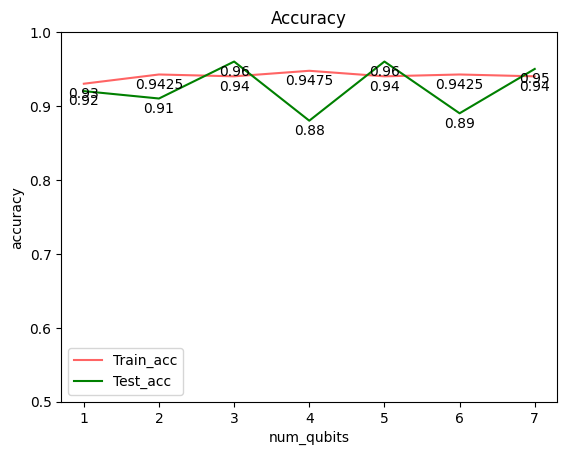

In [51]:
for run_exp, x_label in zip([i != 1 for i in num_settings],data):
    if run_exp:
        fig, ax = plt.subplots(1, 1)
        ax.set_ylim([0.5, 1])
        plt.plot(data[x_label],data['Train_acc'],color=(255/255,100/255,100/255),label='Train_acc')
        plt.plot(data[x_label],data['Test_acc'],color='g',label='Test_acc')
        for i,j,k in zip(data[x_label],data['Train_acc'],data['Test_acc']):
            ax.annotate(f'{j}', xy=(i,j), xytext=(0,-10), textcoords='offset points' ,ha='center')
            ax.annotate(f'{k}', xy=(i,k), xytext=(0,-10), textcoords='offset points' ,ha='center')
        plt.title("Accuracy") # title
        plt.ylabel("accuracy") # y label
        plt.xlabel(x_label) # x label
        plt.legend()
        plt.show()
        fig.savefig(f'Accuracy-{x_label}.png', transparent=True)

In [54]:
def backtrack(n, k, start, path, result):
    if len(path) == k:
        result.append(path[:])
        return
    
    for i in range(start, n + 1):
        path.append(i)
        backtrack(n, k, i, path, result)  # Use i instead of i+1 to allow duplicates
        path.pop()

def generate_combinations(n, k):
    result = []
    backtrack(n, k, 1, [], result)
    return result

# Example usage:
n = 5  # Range from 1 to 5
k = 4  # Length of the array
combinations = generate_combinations(n, k)
print((combinations))


[[1, 1, 1, 1], [1, 1, 1, 2], [1, 1, 1, 3], [1, 1, 1, 4], [1, 1, 1, 5], [1, 1, 2, 2], [1, 1, 2, 3], [1, 1, 2, 4], [1, 1, 2, 5], [1, 1, 3, 3], [1, 1, 3, 4], [1, 1, 3, 5], [1, 1, 4, 4], [1, 1, 4, 5], [1, 1, 5, 5], [1, 2, 2, 2], [1, 2, 2, 3], [1, 2, 2, 4], [1, 2, 2, 5], [1, 2, 3, 3], [1, 2, 3, 4], [1, 2, 3, 5], [1, 2, 4, 4], [1, 2, 4, 5], [1, 2, 5, 5], [1, 3, 3, 3], [1, 3, 3, 4], [1, 3, 3, 5], [1, 3, 4, 4], [1, 3, 4, 5], [1, 3, 5, 5], [1, 4, 4, 4], [1, 4, 4, 5], [1, 4, 5, 5], [1, 5, 5, 5], [2, 2, 2, 2], [2, 2, 2, 3], [2, 2, 2, 4], [2, 2, 2, 5], [2, 2, 3, 3], [2, 2, 3, 4], [2, 2, 3, 5], [2, 2, 4, 4], [2, 2, 4, 5], [2, 2, 5, 5], [2, 3, 3, 3], [2, 3, 3, 4], [2, 3, 3, 5], [2, 3, 4, 4], [2, 3, 4, 5], [2, 3, 5, 5], [2, 4, 4, 4], [2, 4, 4, 5], [2, 4, 5, 5], [2, 5, 5, 5], [3, 3, 3, 3], [3, 3, 3, 4], [3, 3, 3, 5], [3, 3, 4, 4], [3, 3, 4, 5], [3, 3, 5, 5], [3, 4, 4, 4], [3, 4, 4, 5], [3, 4, 5, 5], [3, 5, 5, 5], [4, 4, 4, 4], [4, 4, 4, 5], [4, 4, 5, 5], [4, 5, 5, 5], [5, 5, 5, 5]]


In [42]:
for i in best_h_pm:
    print(h_pms[i])
best_h_pm

[[0.15, 0.05, 0.01], 3200, 50, 50, [0.05, 0.03, 0.01]]
[[0.15, 0.05, 0.01, 0.001, 0.0001], 3200, 100, 50, [0.05, 0.03, 0.01]]
[[0.15, 0.05, 0.01, 0.001, 0.0001], 3200, 50, 50, [0.05, 0.03, 0.01]]
[[0.15, 0.05, 0.01], 3200, 100, 50, [0.05, 0.03, 0.01]]
[[0.15, 0.05, 0.01], 3200, 100, 50, [0.05, 0.03, 0.01]]
[[0.15, 0.05, 0.01], 3200, 300, 50, [0.05, 0.03, 0.01]]
[[0.15, 0.05, 0.01], 3200, 100, 50, [0.05, 0.03, 0.01]]


[0, 4, 3, 1, 1, 2, 1]

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim)
max_search_n=20
n_nodes = []
t1_c = time.process_time()
for f in range(r_f):
    scores=[]
    for n in range(max_search_n):
        size = [n+1]*(f+1)
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                            random_state=data_seed_num,max_iter=6000, warm_start=False)
        score = np.min(cross_val_score(clf, X_train, y_train, cv=10))  
        if score >= data['Test_acc'][f] or n == (max_search_n-1): 
            n_nodes.append(n+1)
            break

sizes = [[n_nodes[f]]*(f+1) for f in range(r_f)]
accuracy_tr, accuracy=[],[]

for size in sizes:
    seed_tr_rsts, seed_rsts = [], []
    for seed in seeds:
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                                random_state=seed,max_iter=6000, warm_start=False)
        clf.fit(X_train, y_train)
        y_pred_tr = clf.predict(X_train)
        y_pred = clf.predict(X_test)
        # report = classification_report(y_test, y_pred)
        seed_tr_rsts.append(accuracy_score(y_train, y_pred_tr))
        seed_rsts.append(accuracy_score(y_test, y_pred))
    accuracy_tr.append(np.average(seed_tr_rsts))
    accuracy.append(np.average(seed_rsts))
t_c_tot = time.process_time()-t1_c
print(f'Time for classical NN: {t_c_tot} s')
print(accuracy_tr)
print(accuracy)
print(data['Test_acc'])
n_nodes

Time for classical NN: 732.7974520000062 s
[0.93875]
[0.869]
[0.92, 0.91, 0.96, 0.88, 0.96, 0.89, 0.95]


[20]

In [44]:
def param_n_model(setting, model='NN'):
    if model=='NN':
        n_nodes = setting
        
        n_params = []
        r_f = len(n_nodes)
        for f in range(r_f):
            n_p=0
            for i in range(f+1):
                n_p=n_p+(len(X_train[0])+1)*n_nodes[f] if i==0  else n_p
                n_p=n_p+(n_nodes[i]+1)*num_class if i==(r_f-1) else n_p
                n_p=n_p+(n_nodes[f]+1)*n_nodes[f] if i!=0 or i!=(r_f-1) else n_p
            n_params.append(n_p)
    if model=='QNN':
        enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
        n_params = (enc_dim +n_rot*3)*num_qubits*num_reupload*num_layers+ num_class* num_qubits

    return n_params
num_params_NN = param_n_model(n_nodes,model='NN')
num_params_QNN = [param_n_model(setting,model='QNN') for setting in settings]

print('Number of params in NN model:', num_params_NN)
print('Number of params in QNN model:', num_params_QNN)

Number of params in NN model: [162]
Number of params in QNN model: [44, 88, 132, 176, 220, 264, 308]


In [ ]:
import pandas as pd
c_values=np.array([n_nodes,accuracy_tr,accuracy,data['Test_acc'],
                   num_params_NN,num_params_QNN,[t_c_tot]*len(settings)])
c_values=np.append(settings,c_values.T, axis=1)
c_data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'num_c_nodes ': [],
        'C_train_acc' : [],
        'C_test_acc' : [],
        'Q_test_acc' : [],
        'num_params_NN' : [],
        'num_params_QNN' : [],
        f'time_{num_seeds}_seeds' : []}
for result in c_values:
    for i,(d,r) in enumerate(zip(c_data,result)):
        if i<6: c_data[d].append(int(r));
        else:   c_data[d].append(float(r))
df = pd.DataFrame(c_data)
df.style.hide()
display(df)
# Export to Excel
excel_file_path = f'classical_data_comparism.xlsx'
sheet_name = 'Sheet1'
df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

In [ ]:
for fx

In [ ]:
from qiskit.providers.fake_provider import FakeBelem
backend = FakeBelem()
# backend.qubit_properties()
from datetime import datetime

t = datetime(day=15, month=4, year=2020, hour=10)
backend.properties(datetime=t)

In [ ]:
X_test.shape

In [ ]:
F = open("{}_settings.txt".format(ver), "a")
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    ), file = F)#)#

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test[:,:], initial_predictions, fig, axes[0])
plot_data(X_test[:,:], predicted_test, fig, axes[1])
plot_data(X_test[:,:], y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Training Accuracy = {} \n Test Accuracy = {}".format(accuracy_train,accuracy_test))
axes[2].set_title("True test data \n # of points = {}".format(num_test))
plt.tight_layout()
plt.show()
fig.savefig('{}_train.png'.format(ver), transparent=True)

In [ ]:
#initialize_data(problem,num_Test,seed_num=seed_num)

In [ ]:
num_Test = 568

X_Test, y_Test = initialize_data(problem,num_Test,seed_num=seed_num)#data_gen(problem,num_Test,seed_num=np.random.randint(num_Test))#circle(num_test)#
predicted_Test, loss, _  = test(params, X_Test, y_Test)
accuracy_Test = accuracy_score(y_Test, predicted_Test)  


print("Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_Test), file = F)



fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_train[:,:,], y_train, fig, axes[0])
plot_data(X_Test[:,:], predicted_Test, fig, axes[1])
plot_data(X_Test[:,:], y_Test, fig, axes[2])
axes[0].set_title("Training data")
axes[1].set_title("Predictions after training \n Accuracy = {}".format(accuracy_Test))
axes[2].set_title("True test data \n # of points = {}".format(num_Test))
plt.tight_layout()
plt.show()
fig.savefig('{}_test.png'.format(ver), transparent=True)
print("process_time ：%f s" % (time.process_time()- end))

In [ ]:
for fx

In [ ]:
%whos 

In [ ]:
# from qiskit_ibm_provider import least_busy
# backend = least_busy(provider.backends(min_num_qubits=5,simulator=False,operational=True))
# backend = backend.name
# print(backend)

In [ ]:
#noisy device
str_error = None
noise=True
noise_num_Test = 100
sleep_time = 2
num_retries = 10
noise_batch_size = 9 if real_device else noise_num_Test
#ver = ver+'_'+backend if noise else ver

noise_start = time.time()
noise_XTest, noise_y_Test = data_gen(problem,noise_num_Test,seed_num=noise_num_Test)#circle(num_test)#
noise_X_Test = np.hstack((np.zeros((noise_num_Test,1)), noise_XTest))
noise_predicted_Test = jnp.array([])
noise_minibatches = iterate_minibatches(noise_X_Test, noise_y_Test, batch_size=noise_batch_size)
backend = 'ibm_algiers'
print(backend,noise_start)

In [ ]:
while True:
    try: 
        if not str_error:
            Xbatch, ybatch = next(noise_minibatches)
        for x in range(0, num_retries):  
            try:
                str_error = 'Calculating...'
                predicted, loss, _  = test(params, Xbatch, ybatch)
                noise_predicted_Test = jnp.append(noise_predicted_Test, predicted)
                print(predicted)
                str_error = None
            except Exception as e:
                str_error = str(e)
                print('err:',str_error)
            if str_error:               # if None->break, if 'some_string'(error happens)->sleep and retry
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 1.5  
                if x==(num_retries-1):
                    print('operation fail')
                else:
                    print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break
noise_end = time.time()

In [ ]:
def device(noise=False,real_device=False,backend=backend,noise_model=None):
    if noise:
        if real_device:
            dev = qml.device('qiskit.ibmq.sampler', wires=2, backend=backend, 
                             provider=provider,initial_layout= [4,7],start_session=True)#)#
        else:
            if not noise_model:
                noise_model = model_noise(backend,fake_backend)
            dev = qml.device('qiskit.aer', wires=2, diff_method="adjoint", noise_model=noise_model)#
    else: 
        dev = qml.device("default.qubit", wires=2)
    return dev
def conditional_qnode(dev,noise=False):
    if noise:
        #print('noise circ operated')
        return qml.qnode(dev) 
    else: 
        return qml.qnode(dev,interface='jax')

In [ ]:
Xbatch, ybatch = next(noise_minibatches)
test(params, Xbatch, ybatch)

In [ ]:
noise_accuracy_Test = accuracy_score(noise_y_Test, noise_predicted_Test)  
print("noise:",noise,", real_device:",real_device,', backend:',backend,', num_noise_Test:',noise_num_Test,file = F)#)#
print("Cost: {:3f} | Noisy Test Accuracy : {:3f}".format(loss, noise_accuracy_Test), file = F)#)#
print("process_time ：%f s" % (noise_end- noise_start), file = F)#)#
print(datetime.datetime.now(), file = F)#)#
print('noise_model:', None if real_device else noise_model, file = F)
F.close()#
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_train, y_train, fig, axes[0])
plot_data(noise_X_Test[:,1:], noise_predicted_Test, fig, axes[1])
plot_data(noise_X_Test[:,1:], noise_y_Test, fig, axes[2])
axes[0].set_title("Training data")
axes[1].set_title("Predictions after training \n Accuracy with noise = {}".format(noise_accuracy_Test))
axes[2].set_title("True test data \n # of points = {}".format(noise_num_Test))
plt.tight_layout()
plt.show()
fig.savefig('{}_noise_test.png'.format(ver), transparent=True)

In [ ]:
qml.about()

In [ ]:
a = [(i,j) for i,j in zip(globals().keys(),globals().values())]
import sys
for i,j in a:
    print(i,sys.getsizeof(j))

In [ ]:
ibm_brisbane

In [ ]:
dev = qml.device('qiskit.ibmq', wires=2, backend=backend, provider=provider)

In [ ]:
# minimum qiskit-runtime connect-testing code

sleep_time = 5
num_retries = 5
str_error = None
initial_layout = [1,2]# None#
backend = 'ibmq_mumbai' #'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout,start_session=True)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian([[1,0],[0,0]],wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                rst = circuit(*databatch)
                print('result:',rst)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break

In [ ]:
dm_labels[0]

In [ ]:
initial_layout = [1,2]#None #
backend = 'ibm_auckland'# 'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])
databatch = next(data)
databatch = next(data)
circuit(*databatch)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session

In [ ]:
##qiskit version
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options

shots = 2048
sleep_time = 5
num_retries = 5
str_error = None
initial_layout = None#[1,2]
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
backend = provider.get_backend('ibmq_jakarta')#'ibm_hanoi')#'ibmq_qasm_simulator')#'ibmq_quito')
runtime_service = QiskitRuntimeService(channel="ibm_quantum")
options = {"backend": backend.name}
def qcircuit(x,y):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circuit = QuantumCircuit(qr, cr)
    circuit.rx(x,qr[0])
    circuit.ry(y,qr[1])
    circuit.cx(qr[0], qr[1])
    circuit.measure(qr, cr)
    mapped_circuit = transpile(circuit, backend=backend)
    return mapped_circuit
data = iter([[0.1,0.2],[0.2,0.3],[0.4,0.5]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                program_inputs = {"circuits": qcircuit(*databatch)  , "shots": shots , 'initial_layout':initial_layout
                                  , 'optimization_level': 3,'start_session': True}
                job = runtime_service.run(program_id="circuit-runner", options=options, inputs=program_inputs)#
                counts = job.result().get_counts()
                print('result:',counts)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break

In [ ]:
circuit(*databatch)

In [ ]:
# provider = IBMProvider()
# dev = qml.device('qiskit.ibmq', wires=2, backend=backend, provider=provider)
# dev.capabilities()['backend']

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
x,y = load_breast_cancer(return_X_y=True)
x.shape